In [4]:
import pandas as pd
import statsmodels.api as sm

# 1. Load the data
df = pd.read_excel('USINV.xlsx', header=0)

# 2. Parse Quarter as a PeriodIndex at freq='Q'
df['Quarter'] = pd.PeriodIndex(df['Quarter'], freq='Q')
df = df.set_index('Quarter').sort_index()

# 3. Create dummy for 1978Q2
df['d_1978q2'] = (df.index == pd.Period('1978Q2')).astype(int)

# 4. Create lags y(-1), y(-2)
df['y_lag1'] = df['y'].shift(1)
df['y_lag2'] = df['y'].shift(2)

# 5. Restrict sample to 1969Q3–1999Q4
start, end = pd.Period('1969Q3'), pd.Period('1999Q4')
df_sample = df.loc[start:end].dropna()

# 6. Define regressors and dependent
X = df_sample[['d_1978q2', 'y_lag1', 'y_lag2']]
X = sm.add_constant(X)       # adds intercept
y = df_sample['y']

# 7. Estimate via OLS
model = sm.OLS(y, X)
results = model.fit()

# Output the summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     20.64
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           8.72e-11
Time:                        00:04:43   Log-Likelihood:                -245.13
No. Observations:                 120   AIC:                             498.3
Df Residuals:                     116   BIC:                             509.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4534      0.203      2.229      0.0

In [8]:
import pandas as pd
import statsmodels.api as sm

# Load & index
df = pd.read_excel('USINV.xlsx', header=0)
df['Quarter'] = pd.PeriodIndex(df['Quarter'], freq='Q')
df = df.set_index('Quarter').sort_index()

# Build outlier dummy at 1980Q2
df['d_1980q2'] = (df.index == pd.Period('1980Q2')).astype(int)

# Trim to 1969Q3–1999Q4
y = df['y'].loc['1969Q3':'1999Q4']
exog = df['d_1980q2'].loc[y.index]

# Set up SARIMAX: AR(2) + constant + exog dummy
mod = sm.tsa.SARIMAX(
    endog=y,
    exog=exog,
    order=(2,0,0),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit by full maximum likelihood (default is 'lbfgs' on the exact llf)
res = mod.fit(disp=False)

print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -244.604
Date:                Fri, 13 Jun 2025   AIC                            499.207
Time:                        00:09:46   BIC                            513.145
Sample:                    09-30-1969   HQIC                           504.867
                         - 12-31-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4827      0.188      2.564      0.010       0.114       0.852
d_1980q2      -6.2526     11.613     -0.538      0.590     -29.014      16.509
ar.L1          0.4112      0.089      4.626      0.0

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy import stats

# ---------- data & dummies (unchanged) ----------
df = pd.read_excel("USINV.xlsx", header=0)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q")
df = df.set_index("Quarter").sort_index()
df["D_1980Q2"] = (df.index == pd.Period("1980Q2")).astype(int)   # IO
df["D_1978Q2"] = (df.index == pd.Period("1978Q2")).astype(int)   # AO
df_s = df.loc["1970Q1":"1999Q4"]

y   = df_s["y"].to_numpy()
d80 = df_s["D_1980Q2"].to_numpy()
d78 = df_s["D_1978Q2"].to_numpy()

# ---------- residual generator ----------
def resid(theta):
    mu, delta, phi1, phi2, gamma = theta
    e = np.empty_like(y)
    e[:2] = 0.0                       # first two undefined
    for t in range(2, len(y)):
        e[t] = (y[t]
                - (mu + delta*d80[t]
                   + phi1*(y[t-1]-mu-delta*d80[t-1])
                   + phi2*(y[t-2]-mu-delta*d80[t-2])
                   + gamma*d78[t]))
    return e[2:]                      # drop first two

# ---------- LM optimisation ----------
theta0 = [y.mean(), 0.0, 0.3, 0.2, 0.0]
out    = least_squares(resid, theta0, method="lm")
bhat   = out.x
J      = out.jac                    # (T-2)×5 Jacobian

# ---------- σ², s.e.,  t,  *p*  ----------
T, k   = len(y)-2, len(bhat)
sigma2 = (out.fun @ out.fun) / (T - k)
cov    = sigma2 * np.linalg.inv(J.T @ J)
se     = np.sqrt(np.diag(cov))
tval   = bhat / se
pval   = 2 * stats.t.sf(np.abs(tval), df=T-k)   ### NEW

# ---------- neatly print ----------
import pandas as pd
tab = pd.DataFrame({"Coef":bhat, "Std.Err":se, "t":tval, "p":pval},
                   index=["μ","δ (1980Q2 IO)","φ₁","φ₂","γ (1978Q2 AO)"])
print(tab.round(4))


                 Coef  Std.Err       t       p
μ              1.1913   0.4297  2.7725  0.0065
δ (1980Q2 IO) -6.2313   1.6421 -3.7946  0.0002
φ₁             0.4227   0.0873  4.8447  0.0000
φ₂             0.1877   0.0874  2.1472  0.0339
γ (1978Q2 AO)  6.6018   1.8255  3.6165  0.0004


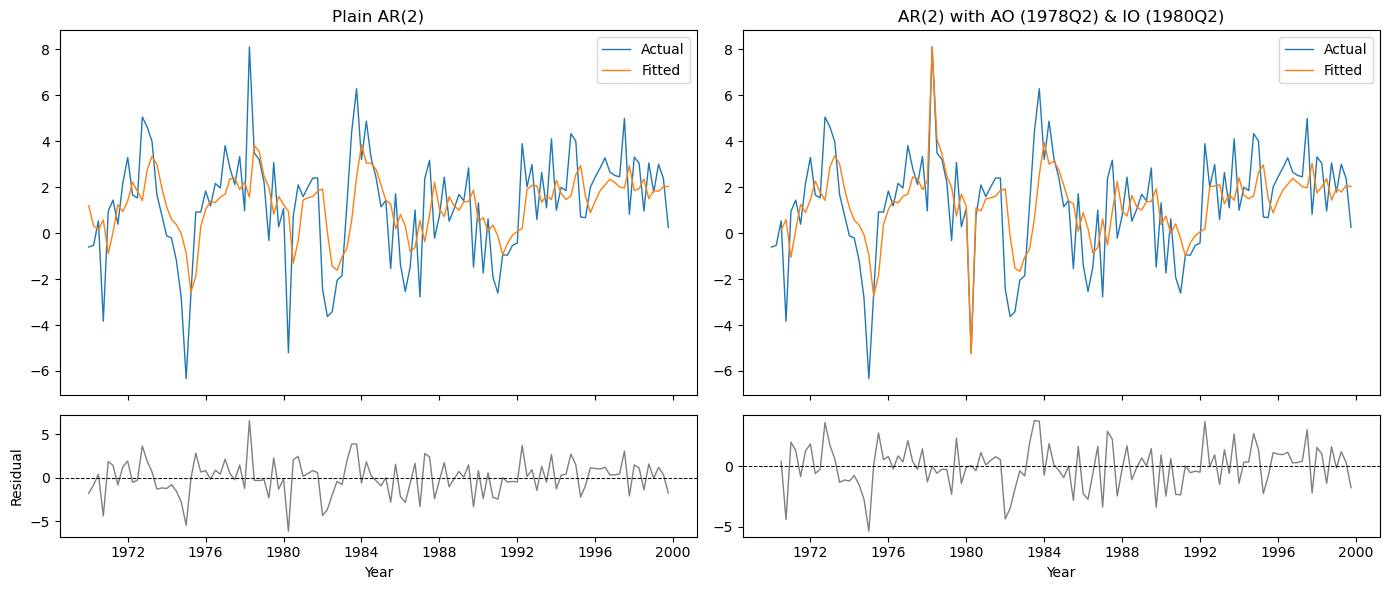

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import least_squares
from scipy import stats

# -------------------------------------------------------------------
# 1. Load data & dummies
# -------------------------------------------------------------------
df = pd.read_excel("USINV.xlsx", header=0)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q")
df = df.set_index("Quarter").sort_index()

df["AO_1978Q2"] = (df.index == pd.Period("1978Q2")).astype(int)
df["IO_1980Q2"] = (df.index == pd.Period("1980Q2")).astype(int)

sample = df.loc["1970Q1":"1999Q4"]
y   = sample["y"]
ao  = sample["AO_1978Q2"]
io  = sample["IO_1980Q2"]

# -------------------------------------------------------------------
# 2. Plain AR(2) (ML)
# -------------------------------------------------------------------
mod_plain = sm.tsa.SARIMAX(y, order=(2,0,0), trend="c")
res_plain = mod_plain.fit(disp=False)
fitted_plain = res_plain.fittedvalues
resid_plain  = y - fitted_plain

# -------------------------------------------------------------------
# 3. AR(2) with AO & IO (LM)
# -------------------------------------------------------------------
def resid_nl(theta):
    mu, delta, phi1, phi2, gamma = theta
    r = np.empty_like(y.values)
    r[:2] = 0.0
    yv, aov, iov = y.values, ao.values, io.values
    for t in range(2, len(yv)):
        r[t] = (yv[t] - (mu + delta*iov[t]
                         + phi1*(yv[t-1]-mu-delta*iov[t-1])
                         + phi2*(yv[t-2]-mu-delta*iov[t-2])
                         + gamma*aov[t]))
    return r[2:]

theta0 = [y.mean(), 0.0, 0.3, 0.2, 0.0]
out    = least_squares(resid_nl, theta0, method="lm")
mu, delta, phi1, phi2, gamma = out.x

fitted_corr = y.copy()
resid_corr  = y.copy()
fitted_corr.iloc[:2] = np.nan
resid_corr.iloc[:2]  = np.nan
for t in range(2, len(y)):
    fitted_corr.iloc[t] = (
        mu + delta*io.iloc[t]
        + phi1*(y.iloc[t-1]-mu-delta*io.iloc[t-1])
        + phi2*(y.iloc[t-2]-mu-delta*io.iloc[t-2])
        + gamma*ao.iloc[t]
    )
    resid_corr.iloc[t] = y.iloc[t] - fitted_corr.iloc[t]

# -------------------------------------------------------------------
# 4. Side-by-side figure: top = Actual & Fitted, bottom = Residual
# -------------------------------------------------------------------
x = y.index.to_timestamp()       # datetime x-axis

fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(14, 6),
    sharex='col', height_ratios=[3, 1]
)

# ------------------------------------------------ LEFT column (plain AR2)
# top panel: actual & fitted
axs[0, 0].plot(x, y,            label="Actual",  linewidth=1)
axs[0, 0].plot(x, fitted_plain, label="Fitted",  linewidth=1)
axs[0, 0].set_title("Plain AR(2)")
axs[0, 0].legend(loc="upper right")

# bottom panel: residual
axs[1, 0].plot(x, resid_plain, color="tab:gray", linewidth=1)
axs[1, 0].axhline(0, linestyle="--", linewidth=0.7, color="black")
axs[1, 0].set_ylabel("Residual")

# ------------------------------------------------ RIGHT column (AO+IO)
# top panel: actual & fitted
axs[0, 1].plot(x, y,              label="Actual", linewidth=1)
axs[0, 1].plot(x, fitted_corr,    label="Fitted", linewidth=1)
axs[0, 1].set_title("AR(2) with AO (1978Q2) & IO (1980Q2)")
axs[0, 1].legend(loc="upper right")

# bottom panel: residual
axs[1, 1].plot(x, resid_corr, color="tab:gray", linewidth=1)
axs[1, 1].axhline(0, linestyle="--", linewidth=0.7, color="black")

# ------------------------------------------------ tidy up
for ax in axs[1, :]:
    ax.set_xlabel("Year")

plt.tight_layout()
plt.show()

In [35]:
"""
AR(2) for US quarterly investment
OLS  vs  Huber-M (c=1.345)  vs  Trimmed OLS (c=2.5, hard trim)

EViews-style optimiser choices:
  • Huber: IRLS with MAD scale
  • TOLS : hard-trim IRLS until weights stabilise

Prints the table of coefficients and s.e.’s.
"""
# !pip install tabulate statsmodels pandas openpyxl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from statsmodels.robust import scale as smscale
from tabulate import tabulate

# ------------------------------------------------------------
# 1.  Data & lags
# ------------------------------------------------------------
df = pd.read_excel("USINV.xlsx")
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q")
df = df.set_index("Quarter").sort_index()

y_full = df.loc["1970Q1":"1999Q4", "y"]
X_full = pd.DataFrame({
    "const": 1.0,
    "y_lag1": y_full.shift(1),
    "y_lag2": y_full.shift(2)
}).dropna()
y_full = y_full.loc[X_full.index]

labels = ["const", "y_lag1", "y_lag2"]

# helper: nice rounding
fmt = lambda arr: [f"{v: .3f}" for v in arr]

# ------------------------------------------------------------
# 2.  OLS  ----------------------------------------------------
ols_res = sm.OLS(y_full, X_full).fit()

# ------------------------------------------------------------
# 3.  Huber-M  (IRLS + MAD) ----------------------------------
hub_res = sm.RLM(
    y_full, X_full,
    M=HuberT(t=1.345),
    init="ls",
    scale_est=smscale.mad,    # <-- EViews uses MAD
    update_scale=True
).fit(maxiter=50, tol=1e-8)

# ------------------------------------------------------------
# 4.  TOLS  (hard trim |u|>2.5 until convergence) ------------
# ------------------------------------------------------------
def hard_trim_loop(y, X, c=2.5, maxiter=25):
    # start with LS
    res = sm.OLS(y, X).fit()
    for _ in range(maxiter):
        sigma = smscale.mad(res.resid, center=0)      # MAD like EViews
        u = res.resid / sigma
        w = (np.abs(u) <= c).astype(float)
        res_new = sm.WLS(y, X, weights=w).fit()
        if np.array_equal(w, res_new.model.weights):  # weights stable
            break
        res = res_new
    return res_new

tols_res = hard_trim_loop(y_full, X_full, c=2.5)

# ------------------------------------------------------------
# 5.  Assemble results
# ------------------------------------------------------------
rows = []
for name, res in [("OLS", ols_res), ("Huber", hub_res), ("TOLS", tols_res)]:
    coefs = res.params.reindex(labels).values
    ses   = res.bse.reindex(labels).values
    rows.append([name] + fmt(coefs) + [f"({s: .3f})" for s in ses])

headers = ["Method", "μ̂", "ϕ̂₁", "ϕ̂₂",
           "s.e.(μ̂)", "s.e.(ϕ̂₁)", "s.e.(ϕ̂₂)"]
print(tabulate(rows, headers=headers, tablefmt="pretty"))


+--------+-------+-------+-------+----------+----------+----------+
| Method |   μ̂   |  ϕ̂₁   |  ϕ̂₂   | s.e.(μ̂)  | s.e.(ϕ̂₁) | s.e.(ϕ̂₂) |
+--------+-------+-------+-------+----------+----------+----------+
|  OLS   | 0.515 | 0.384 | 0.214 | ( 0.216) | ( 0.091) | ( 0.091) |
| Huber  | 0.629 | 0.355 | 0.199 | ( 0.208) | ( 0.088) | ( 0.088) |
|  TOLS  | 0.634 | 0.372 | 0.168 | ( 0.191) | ( 0.080) | ( 0.080) |
+--------+-------+-------+-------+----------+----------+----------+


/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['init', 'scale_est', 'update_scale']
  warnings.warn(msg, ValueWarning)


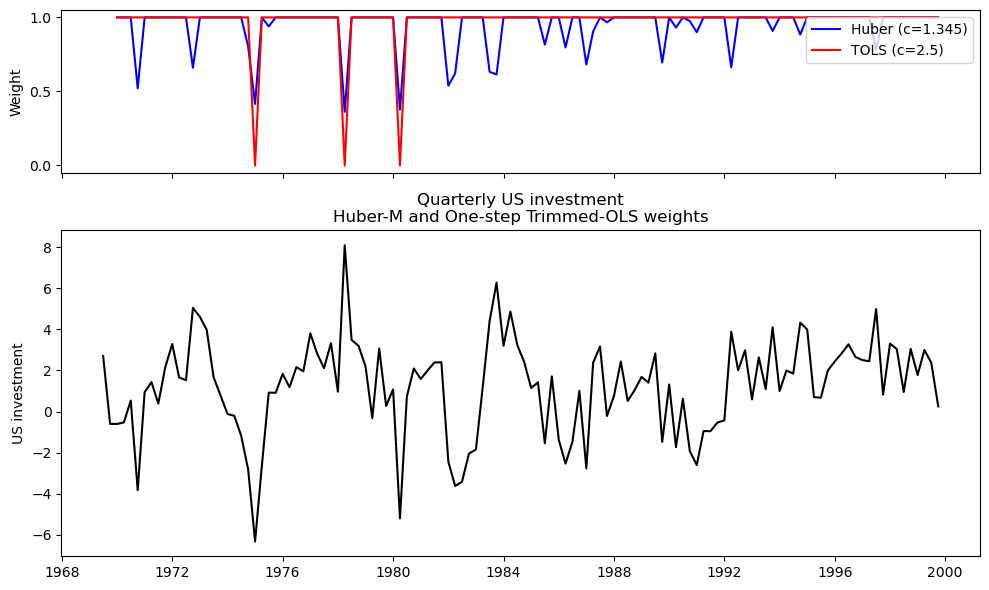

In [36]:
"""
One-step Trimmed-OLS (red) vs Huber-M (blue) weights for AR(2),
so the slide’s exact spikes (and no extra ones) are flagged.

• Huber-M: full IRLS via RLM (ψ(u)/u).
• TOLS   : one-step trim based on initial OLS residuals.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from statsmodels.robust import scale as smscale   # for mad()

# 1) Load 1969Q3–1999Q4 so 1970Q1 is in-sample
df = pd.read_excel("USINV.xlsx")
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q")
df = df.set_index("Quarter").sort_index()
y_full = df.loc["1969Q3":"1999Q4", "y"]
t = y_full.index.to_timestamp()

# Build AR(2) regressors & define sample
Xc = pd.DataFrame({
    "const": 1.0,
    "y_lag1": y_full.shift(1),
    "y_lag2": y_full.shift(2)
}).dropna()
y = y_full.loc[Xc.index]

pad = pd.Series(index=y_full.index.difference(Xc.index), dtype=float)

# 2) Huber-M via RLM
hub = sm.RLM(y, Xc, M=HuberT(t=1.345)).fit()
u_h = hub.resid / hub.scale
psi = hub.model.M.psi(u_h)
w_h = np.where(u_h==0, 1.0, psi/u_h)
w_huber = pd.concat([pad, pd.Series(w_h, index=Xc.index)]).sort_index()

# 3) One-step TOLS
ols = sm.OLS(y, Xc).fit()
sigma_ols = np.sqrt(ols.ssr / ols.df_resid)     # OLS σ
u0 = ols.resid / sigma_ols
w_t = (np.abs(u0) <= 2.5).astype(float)
w_tols = pd.concat([pad, pd.Series(w_t, index=Xc.index)]).sort_index()

# 4) Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6),
                               sharex=True,
                               gridspec_kw={"height_ratios":[1,2]})

ax1.plot(t, w_huber, color="blue", label="Huber (c=1.345)")
ax1.plot(t, w_tols,  color="red",  label="TOLS (c=2.5)")
ax1.set_ylim(-0.05,1.05)
ax1.set_yticks([0,0.5,1])
ax1.set_ylabel("Weight")
ax1.legend(loc="upper right")

ax2.plot(t, y_full, color="black")
ax2.set_ylabel("US investment")
ax2.set_title("Quarterly US investment\nHuber-M and One-step Trimmed-OLS weights")

plt.tight_layout()
plt.show()
